In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import datetime as dt
# sklearn stuff
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

#yellobrick stuff
from yellowbrick.classifier import ConfusionMatrix, DiscriminationThreshold, PrecisionRecallCurve, ClassificationReport, ClassPredictionError, ROCAUC
from yellowbrick.target import ClassBalance
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [95]:
def imply_season(month):
    return 'Summer' if month in [12, 1, 2] else 'Fall' if month in [3, 4, 5] else 'Spring' if month in [9, 10, 11] else 'Winter' 

def analyze_classifier(model, X_train, X_test, y_train, y_test, response='Response', classes=[1, 2, 3]):
#    room_types = {
#    'Entire home/apt':1,
#    'Private room':2,
#    'Shared room': 3
#}
    
    matrix = ConfusionMatrix(model)
    matrix.fit(X_train, y_train[response])
    matrix.score(X_test, y_test[response])
    matrix.show()
    class_report = ClassificationReport(model, support=True)
    class_report.fit(X_train, y_train[response])
    class_report.score(X_test, y_test[response])
    class_report.show()
    roc_auc = ROCAUC(model)
    roc_auc.fit(X_train, y_train[response])
    roc_auc.score(X_test, y_test[response])
    roc_auc.show()
    #disc_thresh = DiscriminationThreshold(model)
    #disc_thresh.fit(X_train, y_train.values.ravel())
    #disc_thresh.show()
    recall = PrecisionRecallCurve(model)
    recall.fit(X_train, y_train)
    recall.score(X_test, y_test)
    recall.show()
    return disc_thresh.thresholds_, disc_thresh.cv_scores_

def sklearn_vif(exogs, data):

    # initialize dictionaries
    vif_dict, tolerance_dict = {}, {}

    # form input data for each exogenous variable
    for exog in exogs:
        #print(exog)
        not_exog = [i for i in exogs if i != exog]
        #print(not_exog)
        X, y = data[not_exog], data[exog]

        # extract r-squared from the fit
        r_squared = LinearRegression().fit(X, y).score(X, y)

        # calculate VIF
        vif = 1/(1 - r_squared)
        vif_dict[exog] = vif

        # calculate tolerance
        tolerance = 1 - r_squared
        tolerance_dict[exog] = tolerance

    # return VIF DataFrame
    df_vif = pd.DataFrame({'VIF': vif_dict, 'Tolerance': tolerance_dict})

    return df_vif

def compute_new_conf_matrix(predictions, probabilities, cutoff, y_test):
    #create a df of predictions and probabilities
    predictions = pd.DataFrame(list(predictions), columns=['Predict'])
    predicted_probs = pd.concat([pd.DataFrame(list(probabilities), columns=['ProbFalse', 'ProbTrue']), predictions], axis=1)
    #make array of values where val > cutoff
    predicted_probs['NewPredict'] = predicted_probs['ProbTrue'].apply(lambda x: 1 if x >= cutoff else 0)
    matrix = pd.DataFrame(confusion_matrix(y_test, predicted_probs.NewPredict))
    matrix.rename(columns={0:'No_Predicted',
                            1:'Yes_Predicted'}, 
                  index={0:'No_True',
                            1:'Yes_True'},
                  inplace=True)
    return round(accuracy_score(y_test, predicted_probs.NewPredict),5), matrix, predicted_probs
    

### Load/Clean Data

In [52]:
data = pd.read_csv('AB_NYC_2019.csv')
#data['Month'] = pd.to_datetime(data['Date']).dt.month
#data['Season'] =  data['Month'].apply(lambda x: imply_season(x)).astype('category')
#data['Month'] = data['Month'].astype('category')
#data['Response'] = data['RainTomorrow'].apply(lambda x: 1 if x == 'Yes' else 0) 
#data['RainTomorrow'] = data['RainTomorrow'].astype('category')
#data['WindGustDir'] = data['WindGustDir'].astype('category')
#data['WindDir9am'] = data['WindDir9am'].astype('category')
#data['WindDir3pm'] = data['WindDir3pm'].astype('category')
#data['RainToday'] = data['RainToday'].astype('category')
#data['Location'] = data['Location'].astype('category')

#OHE wind directions and RainToday (label encoder assumes ordinal?)
#data.drop(columns=['Date', 'RISK_MM'], inplace=True)
summary = data.describe()
print({x:len(data[x].unique()) for x in data.columns})
summary

{'id': 48895, 'name': 47906, 'host_id': 37457, 'host_name': 11453, 'neighbourhood_group': 5, 'neighbourhood': 221, 'latitude': 19048, 'longitude': 14718, 'room_type': 3, 'price': 674, 'minimum_nights': 109, 'number_of_reviews': 394, 'last_review': 1765, 'reviews_per_month': 938, 'calculated_host_listings_count': 47, 'availability_365': 366}


,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.889500e+04,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,1.901714e+07,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,1.098311e+07,7.861097e+07,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.471945e+06,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.967728e+07,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,2.915218e+07,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


In [53]:
print(data['neighbourhood_group'].unique())
print(data['room_type'].unique())
len(data[data['last_review'].isna()])

['Brooklyn' 'Manhattan' 'Queens' 'Staten Island' 'Bronx']
['Private room' 'Entire home/apt' 'Shared room']


10052

### Need to bucket some of these values (too much cardinality)

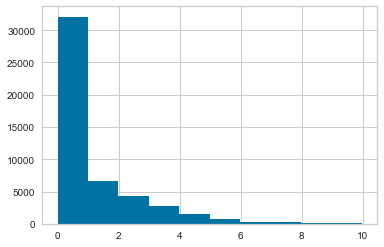

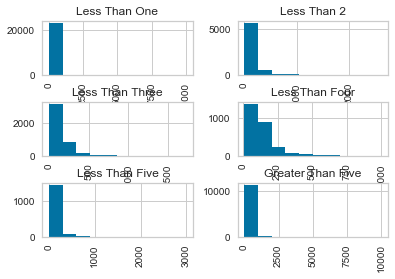

In [57]:
data[data.reviews_per_month < 10]['reviews_per_month'].hist(bins=10)
#appropriate bins are 1, 2, 3, 4, 5
data['reviews_per_month'].fillna(0, inplace=True)
data['reviews_per_month_cut'] = pd.cut(data.reviews_per_month, bins=range(0,6)
                                       , labels=['Less Than One', 'Less Than 2', 'Less Than Three', 'Less Than Four', 'Less Than Five'])
data['reviews_per_month_cut'].cat.add_categories(['Greater Than Five'], inplace=True)
data.loc[data.reviews_per_month_cut.isna(), ['reviews_per_month_cut']] = 'Greater Than Five'
data['price'].hist(by=data['reviews_per_month_cut'])

features = ['neighbourhood_group'
            , 'neighbourhood'
            , 'latitude'
            , 'longitude'
            , 'price'
            , 'minimum_nights'
            , 'number_of_reviews'
            , 'reviews_per_month'
            , 'calculated_host_listings_count'
            , 'availability_365']

target = 'room_type'
data['neighbourhood_group'] = data['neighbourhood_group'].astype('category')
data['neighbourhood'] = data['neighbourhood'].astype('category')
data['last_review'] = pd.to_datetime(data['last_review'])
data['days_since_last_review'] = (dt.datetime.strptime('2020-01-01', '%Y-%m-%d') - data['last_review']).dt.days



data.days_since_last_review.fillna(data.days_since_last_review.max(), inplace=True) 

In [58]:
data.drop(columns=['id', 'name', 'host_id', 'host_name'], inplace=True)

KeyError: "['id' 'name' 'host_id' 'host_name'] not found in axis"

In [59]:
data.describe()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,days_since_last_review
count,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000
mean,40.728949,-73.952170,152.720687,7.029962,23.274466,1.090910,7.143982,112.781327,1018.678331
std,0.054530,0.046157,240.154170,20.510550,44.550582,1.597283,32.952519,131.622289,1169.872743
min,40.499790,-74.244420,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,177.000000
25%,40.690100,-73.983070,69.000000,1.000000,1.000000,0.040000,1.000000,0.000000,196.000000
50%,40.723070,-73.955680,106.000000,3.000000,5.000000,0.370000,1.000000,45.000000,363.000000
75%,40.763115,-73.936275,175.000000,5.000000,24.000000,1.580000,2.000000,227.000000,1378.000000
max,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000,3201.000000


In [60]:
data['price'] = data['price'].astype('float')
data['minimum_nights'] = data['minimum_nights'].astype('float')
data['number_of_reviews'] = data['number_of_reviews'].astype('float')
data['calculated_host_listings_count'] = data['calculated_host_listings_count'].astype('float')
data['availability_365'] = data['availability_365'].astype('float')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x146733ac8>,
      dtype=object)

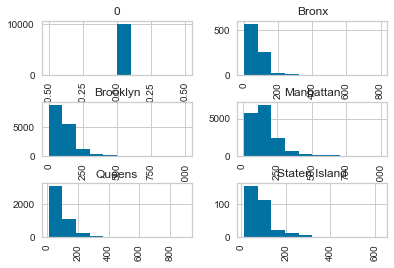

In [94]:
data[data.price < 1000]['price'].hist(by=data['neighbourhood_group'])

In [35]:
data.groupby(['neighbourhood_group', 'room_type'])[['price']].mean().sort_values(['price'], ascending=False)

price
neighbourhood_group room_type                  
Manhattan           Entire home/apt  249.239109
Brooklyn            Entire home/apt  178.327545
Staten Island       Entire home/apt  173.846591
Queens              Entire home/apt  147.050573
Bronx               Entire home/apt  127.506596
Manhattan           Private room     116.776622
                    Shared room       88.977083
Brooklyn            Private room      76.500099
Queens              Private room      71.762456
                    Shared room       69.020202
Bronx               Private room      66.788344
Staten Island       Private room      62.292553
Bronx               Shared room       59.800000
Staten Island       Shared room       57.444444
Brooklyn            Shared room       50.527845

In [40]:
data.groupby(['Location'])[['Response']].mean().sort_values(['Response'], ascending=False).head(10)
#let's look for a more logical grouping than location.... 

,Response
Location,
Portland,0.365487
Walpole,0.336644
Cairns,0.317938
Dartmoor,0.313286
NorfolkIsland,0.310054
MountGambier,0.303630
Albany,0.299072
Witchcliffe,0.297764
CoffsHarbour,0.294277


In [41]:
data.groupby(['Month'])[['Response']].mean().sort_values(['Response'], ascending=False)

,Response
Month,
7,0.269208
6,0.261845
8,0.252508
9,0.229705
5,0.225278
4,0.217849
3,0.213332
11,0.212547
2,0.209691


In [42]:
data.groupby(['Season'])[['Response']].mean().sort_values(['Response'], ascending=False)

,Response
Season,
Winter,0.261202
Fall,0.218868
Spring,0.212424
Summer,0.203030


In [43]:
data.groupby(['RainToday'])[['Response']].mean().sort_values(['Response'], ascending=False)

,Response
RainToday,
Yes,0.464060
No,0.151868


Text(0, 0.5, 'Rain Freq')

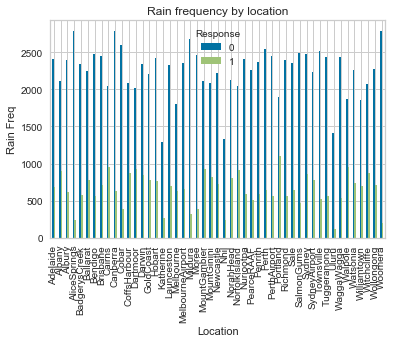

In [44]:
%matplotlib inline
pd.crosstab(data.Location, data.Response).plot(kind='bar')
plt.title('Rain frequency by location')
plt.xlabel('Location')
plt.ylabel('Rain Freq')

Text(0, 0.5, 'Rain Freq')

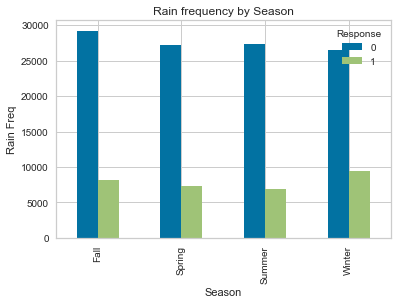

In [45]:
%matplotlib inline
pd.crosstab(data.Season, data.Response).plot(kind='bar')
plt.title('Rain frequency by Season')
plt.xlabel('Season')
plt.ylabel('Rain Freq')

Text(0, 0.5, 'Rain Freq')

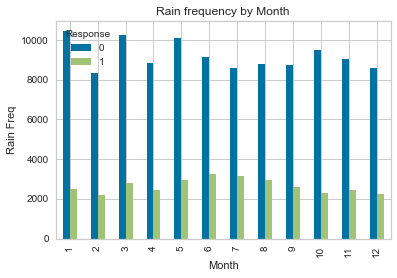

In [46]:
%matplotlib inline
pd.crosstab(data.Month, data.Response).plot(kind='bar')
plt.title('Rain frequency by Month')
plt.xlabel('Month')
plt.ylabel('Rain Freq')

Text(0, 0.5, 'Rain Freq')

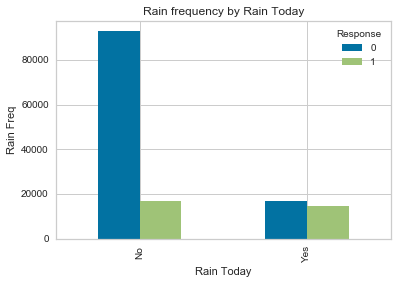

In [47]:
%matplotlib inline
pd.crosstab(data.RainToday, data.Response).plot(kind='bar')
plt.title('Rain frequency by Rain Today')
plt.xlabel('Rain Today')
plt.ylabel('Rain Freq')

Text(0, 0.5, 'Rain Freq')

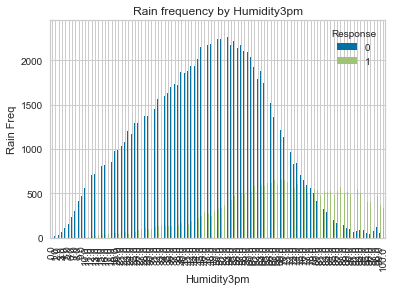

In [48]:
%matplotlib inline
pd.crosstab(data.Humidity3pm, data.Response).plot(kind='bar')
plt.title('Rain frequency by Humidity3pm')
plt.xlabel('Humidity3pm')
plt.ylabel('Rain Freq')

Text(0, 0.5, 'Rain Freq')

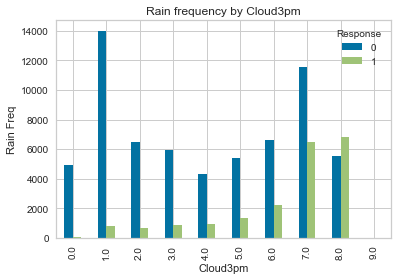

In [49]:
%matplotlib inline
pd.crosstab(data.Cloud3pm, data.Response).plot(kind='bar')
plt.title('Rain frequency by Cloud3pm')
plt.xlabel('Cloud3pm')
plt.ylabel('Rain Freq')

Text(0, 0.5, 'Rain Freq')

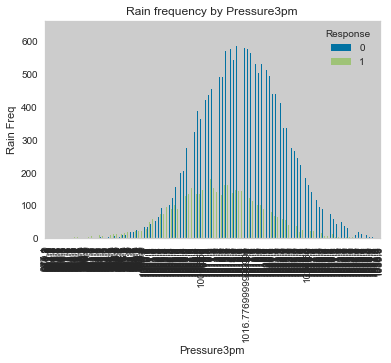

In [50]:
%matplotlib inline
pd.crosstab(data.Pressure3pm, data.Response).plot(kind='bar')
plt.title('Rain frequency by Pressure3pm')
plt.xlabel('Pressure3pm')
plt.ylabel('Rain Freq')

In [51]:
data.groupby(['WindDir9am'])[['Response']].mean().sort_values(['Response'], ascending=False)

,Response
WindDir9am,
NNW,0.309949
N,0.308084
NW,0.279350
WNW,0.270781
NNE,0.268873
W,0.261138
WSW,0.247260
SW,0.231759
SSW,0.220865


### Data Transforms

    - OHE Encode all categoricals
    - Standard Scale all numerics (sklearn is not R - it does not do this by default)
    - This needs to be done on train/test set separately (create a pipeline) 
    
    https://scikit-learn.org/stable/modules/cross_validation.html
    
    https://scikit-learn.org/stable/modules/compose.html#combining-estimators

In [61]:
data_final = data
#OH encode 
label_encode = [x for x, y in dict(data_final.dtypes).items() if type(y) == pd.CategoricalDtype]
for var in label_encode:
    #impute to Mode
    print(f"{var} was OHE'd")
    data_final[var].fillna(data_final[var].mode()[0], inplace=True)
    cat_list = f'var_{var}'
    cat_list = pd.get_dummies(data[var], prefix=var)
    data_new = data_final.join(cat_list)
    data_final = data_new

normalize =  [x for x, y in dict(data_final.dtypes).items() if y == np.float64]
for col in normalize:
        #change impution scheme?
        print(f"{col} was Standard Scaled")
        data_final[col].fillna(data_final[col].median(), inplace=True)
        normalizer = StandardScaler()
        ar = data_final[col].to_numpy().reshape(-1, 1)
        normalizer.fit(ar)
        data_final.loc[:,col] = normalizer.transform(ar)

data_final.drop(columns=label_encode, inplace=True)
#data.fillna(0, inplace=True)
data_final.describe()

neighbourhood_group was OHE'd
neighbourhood was OHE'd
reviews_per_month_cut was OHE'd
latitude was Standard Scaled
longitude was Standard Scaled
price was Standard Scaled
minimum_nights was Standard Scaled
number_of_reviews was Standard Scaled
reviews_per_month was Standard Scaled
calculated_host_listings_count was Standard Scaled
availability_365 was Standard Scaled
days_since_last_review was Standard Scaled


,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,days_since_last_review,neighbourhood_group_Bronx,...,neighbourhood_Woodhaven,neighbourhood_Woodlawn,neighbourhood_Woodrow,neighbourhood_Woodside,reviews_per_month_cut_Less Than One,reviews_per_month_cut_Less Than 2,reviews_per_month_cut_Less Than Three,reviews_per_month_cut_Less Than Four,reviews_per_month_cut_Less Than Five,reviews_per_month_cut_Greater Than Five
count,4.889500e+04,4.889500e+04,4.889500e+04,4.889500e+04,4.889500e+04,4.889500e+04,4.889500e+04,48895.000000,4.889500e+04,48895.000000,...,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000
mean,3.951661e-14,1.661660e-13,3.720195e-17,1.104433e-17,1.860098e-17,4.650244e-18,-1.860098e-17,0.000000,-9.300488e-18,0.022313,...,0.001800,0.000225,0.000020,0.004806,0.469066,0.125637,0.084630,0.053993,0.031087,0.235586
std,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010,1.000010e+00,0.147701,...,0.042386,0.014998,0.004522,0.069161,0.499047,0.331443,0.278334,0.226007,0.173555,0.424369
min,-4.202474e+00,-6.331760e+00,-6.359342e-01,-2.939962e-01,-5.224332e-01,-6.829856e-01,-1.864514e-01,-0.856865,-7.194688e-01,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-7.124376e-01,-6.694733e-01,-3.486158e-01,-2.939962e-01,-4.999866e-01,-6.579428e-01,-1.864514e-01,-0.856865,-7.032276e-01,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-1.078110e-01,-7.605436e-02,-1.945465e-01,-1.964844e-01,-4.102001e-01,-4.513398e-01,-1.864514e-01,-0.514974,-5.604755e-01,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6.265619e-01,3.443653e-01,9.277183e-02,-9.897262e-02,1.628580e-02,3.062045e-01,-1.561044e-01,0.867785,3.071491e-01,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.376357e+00,5.181954e+00,4.100441e+01,6.060212e+01,1.359649e+01,3.594209e+01,9.706672e+00,1.916250,1.865454e+00,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [62]:
data_final.dtypes['availability_365']

dtype('float64')

In [63]:
room_types = {
    'Entire home/apt':1,
    'Private room':2,
    'Shared room': 3
}
data_final['Response'] = data_final.apply(lambda x: room_types[x.room_type], axis=1)

### Feature / Target Split

In [78]:
features, target =  data_final.drop(columns=['Response']), data_final.loc[:,['Response']]
features.shape, target.shape

((48895, 241), (48895, 1))

### Train/Test Split

ClassBalance(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x000001F62B938D30>,
             colormap=None, colors=None,
             labels=['Entire home/apt', 'Private room', 'Shared room'])

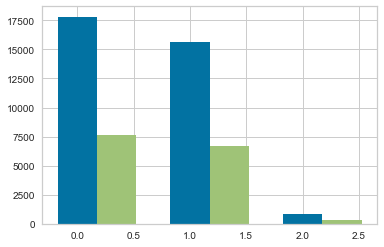

In [79]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=0)
classes_test = ClassBalance(labels=['Entire home/apt', 'Private room', 'Shared room'])
classes_test.fit(y_train['Response'], y_test['Response']) 

### Baseline accuracy rates

In [55]:
baseline_accuracy_train, baseline_accuracy_test = (1-y_train[y_train.Response == 1].shape[0]/y_train.shape[0]) , (1-y_test[y_test.Response == 1].shape[0]/y_test.shape[0])
baseline_accuracy_train, baseline_accuracy_test

(0.7764103079318833, 0.7744385578320596)

### Feature Eng 

    - opted for selection via inspection

In [56]:
#from sklearn.feature_selection import RFE
#rfe = RFE(lgrg, 50)
#rfe = rfe.fit(X_train, y_train.values.ravel())

In [74]:
#X_train_fe = X_train[X_train.columns[rfe.support_]]
#X_test_fe = X_test[X_test.columns[rfe.support_]]
data.dtypes

neighbourhood_group                     category
neighbourhood                           category
latitude                                 float64
longitude                                float64
room_type                                 object
price                                    float64
minimum_nights                           float64
number_of_reviews                        float64
last_review                       datetime64[ns]
reviews_per_month                        float64
calculated_host_listings_count           float64
availability_365                         float64
reviews_per_month_cut                   category
days_since_last_review                   float64
dtype: object

In [81]:
dict(X_train.dtypes)


{'latitude': dtype('float64'),
 'longitude': dtype('float64'),
 'price': dtype('float64'),
 'minimum_nights': dtype('float64'),
 'number_of_reviews': dtype('float64'),
 'reviews_per_month': dtype('float64'),
 'calculated_host_listings_count': dtype('float64'),
 'availability_365': dtype('float64'),
 'days_since_last_review': dtype('float64'),
 'neighbourhood_group_Bronx': dtype('uint8'),
 'neighbourhood_group_Brooklyn': dtype('uint8'),
 'neighbourhood_group_Manhattan': dtype('uint8'),
 'neighbourhood_group_Queens': dtype('uint8'),
 'neighbourhood_group_Staten Island': dtype('uint8'),
 'neighbourhood_Allerton': dtype('uint8'),
 'neighbourhood_Arden Heights': dtype('uint8'),
 'neighbourhood_Arrochar': dtype('uint8'),
 'neighbourhood_Arverne': dtype('uint8'),
 'neighbourhood_Astoria': dtype('uint8'),
 'neighbourhood_Bath Beach': dtype('uint8'),
 'neighbourhood_Battery Park City': dtype('uint8'),
 'neighbourhood_Bay Ridge': dtype('uint8'),
 'neighbourhood_Bay Terrace': dtype('uint8'),
 'ne

### Fit a Logistic on all predictors

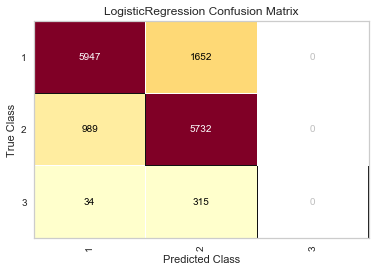

c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


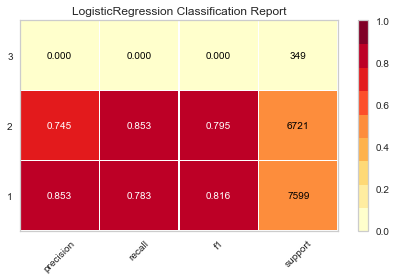

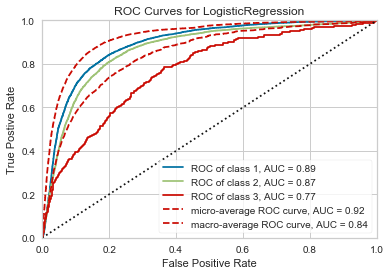

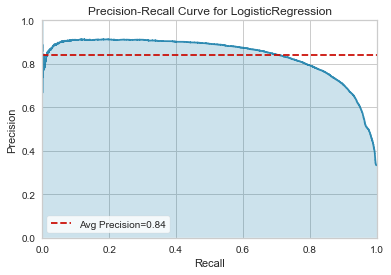

NameError: name 'disc_thresh' is not defined

In [96]:
lgrg_all = LogisticRegression(C=0.01
                          , solver='liblinear'
                          , dual=False
                          , fit_intercept=True
                          , intercept_scaling=1
                          #, l1_ratio=None
                          , max_iter=100
                          , multi_class='auto'
                          , n_jobs=None
                          , penalty='l2'
                          , random_state=0
                          , tol=0.0001
                          , verbose=0
                          , warm_start=False)

lgrg_all.fit(X_train, y_train.values.ravel())
cutoffs_lgrg_all, scores_lgrg_all = analyze_classifier(lgrg_all, X_train, X_test, y_train, y_test)
predict_logit_all = lgrg_all.predict(X_test)
prob_logit_all = lgrg_all.predict_proba(X_test)
best_cutoff_lgrg_all = 0.4# = pd.Series(cutoffs_lgrg_all)[pd.Series(list(scores_lgrg_all['fscore'])).idxmax()]
adj_acc_logit_all, adj_conf_matrix_logit_all, new_preds_logit_all = compute_new_conf_matrix(predict_logit_all, prob_logit_all, best_cutoff_lgrg_all, y_test)
acc_logit_all = round(accuracy_score(y_test, predict_logit_all),5)
print(f'Logit (all features) Accuracy {acc_logit_all}')
print(f'Cutoff ({round(best_cutoff_lgrg_all,4)}) adjusted accuracy: {adj_acc_logit_all}')
print(new_preds_logit_all.iloc[new_preds_logit_all[new_preds_logit_all.Predict == 1]['ProbTrue'].argmin()])
print(new_preds_logit_all.iloc[new_preds_logit_all[new_preds_logit_all.NewPredict == 1]['ProbTrue'].argmin()])
print(f'50/50 Accuracy {acc_logit_all} is {"better than baseline" if acc_logit_all > baseline_accuracy_test else "worse than baseline"}')
print(f'Cutoff Adjusted Accuracy {adj_acc_logit_all} is {"better than baseline" if adj_acc_logit_all > baseline_accuracy_test else "worse than baseline"}')
adj_conf_matrix_logit_all

### Cols chosen from intuition/EDA

In [98]:
X_train_fe = X_train#[['Humidity3pm', 'Cloud3pm', 'Pressure3pm', 'RainToday_Yes', 'Season_Winter']]#, 'Season_Summer', 'Season_Fall', 'Season_Spring']]
X_test_fe = X_test#[['Humidity3pm', 'Cloud3pm', 'Pressure3pm', 'RainToday_Yes', 'Season_Winter']]#, 'Season_Summer', 'Season_Fall', 'Season_Spring']]

### Basic logistic regression

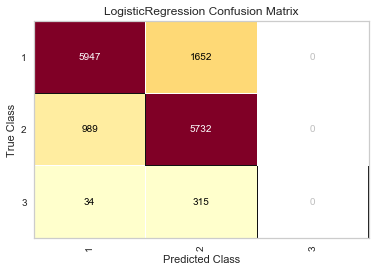

c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


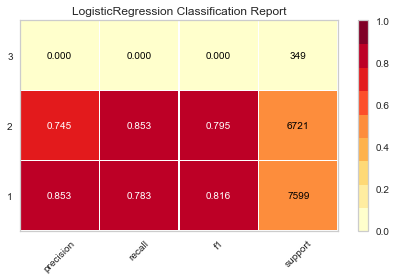

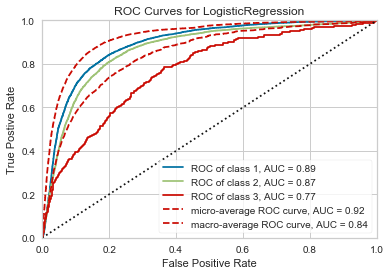

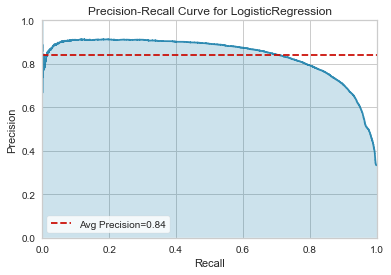

NameError: name 'disc_thresh' is not defined

In [99]:
lgrg = LogisticRegression(C=0.01
                          , solver='liblinear'
                          , dual=False
                          , fit_intercept=True
                          , intercept_scaling=1
                          #, l1_ratio=None
                          , max_iter=100
                          , multi_class='auto'
                          , n_jobs=None
                          , penalty='l2'
                          , random_state=0
                          , tol=0.0001
                          , verbose=0
                          , warm_start=False)

lgrg.fit(X_train_fe, y_train.values.ravel())
cutoffs_lgrg, scores_lgrg = analyze_classifier(lgrg, X_train_fe, X_test_fe, y_train, y_test)
predict_logit = lgrg.predict(X_test_fe)
prob_logit = lgrg.predict_proba(X_test_fe)
best_cutoff_lgrg = pd.Series(cutoffs_lgrg)[pd.Series(list(scores_lgrg['fscore'])).idxmax()]
adj_acc_logit, adj_conf_matrix_logit, new_preds_logit = compute_new_conf_matrix(predict_logit, prob_logit, best_cutoff_lgrg, y_test)
acc_logit = round(accuracy_score(y_test, predict_logit),5)
print(f'Logit Accuracy {acc_logit}')
print(f'Cutoff ({round(best_cutoff_lgrg,4)}) adjusted accuracy: {adj_acc_logit}')
print(new_preds_logit.iloc[new_preds_logit[new_preds_logit.Predict == 1]['ProbTrue'].argmin()])
print(new_preds_logit.iloc[new_preds_logit[new_preds_logit.NewPredict == 1]['ProbTrue'].argmin()])
print(f'50/50 Accuracy {acc_logit} is {"better than baseline" if acc_logit > baseline_accuracy_test else "worse than baseline"}')
print(f'Cutoff Adjusted Accuracy {adj_acc_logit} is {"better than baseline" if adj_acc_logit > baseline_accuracy_test else "worse than baseline"}')
adj_conf_matrix_logit

### LDA 

 - number of components = 1 (# of reponse variables - 1)

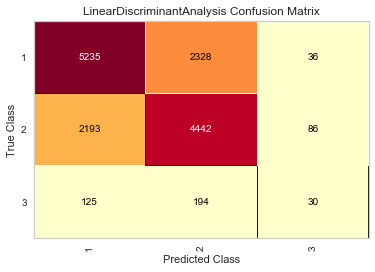

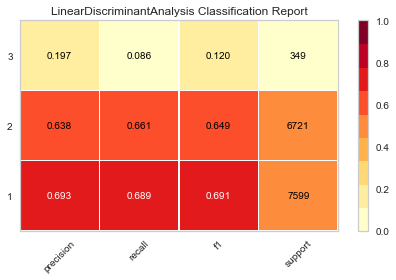

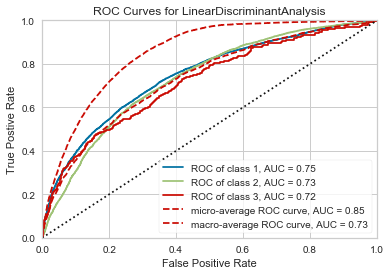

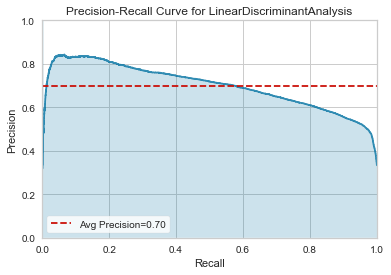

NameError: name 'disc_thresh' is not defined

In [100]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA(n_components=1)
X_train_continuous = X_train_fe#[[x for x, y in dict(X_train_fe.dtypes).items() if y == np.float64]]
X_test_continuous = X_test_fe#[[x for x, y in dict(X_test_fe.dtypes).items() if y == np.float64]]
lda.fit(X_train_continuous, y_train.values.ravel())
cutoffs_lda, scores_lda = analyze_classifier(lda, X_train_continuous, X_test_continuous, y_train, y_test)
predict_lda = lda.predict(X_test_fe)
prob_lda = lda.predict_proba(X_test_fe)
best_cutoff_lda = pd.Series(cutoffs_lda)[pd.Series(list(scores_lda['fscore'])).idxmax()]
adj_acc_lda, adj_conf_matrix_lda, new_preds_lda = compute_new_conf_matrix(predict_lda, prob_lda, best_cutoff_lda, y_test)
acc_lda = round(accuracy_score(y_test, predict_lda),5)
print(f'LDA Accuracy {acc_lda}')
print(f'Cutoff ({round(best_cutoff_lda,4)}) adjusted accuracy: {adj_acc_lda}')
print(new_preds_lda.iloc[new_preds_lda[new_preds_lda.Predict == 1]['ProbTrue'].argmin()])
print(new_preds_lda.iloc[new_preds_lda[new_preds_lda.NewPredict == 1]['ProbTrue'].argmin()])
print(f'50/50 Accuracy {acc_lda} is {"better than baseline" if acc_lda > baseline_accuracy_test else "worse than baseline"}')
print(f'Cutoff Adjusted Accuracy {adj_acc_lda} is {"better than baseline" if adj_acc_lda > baseline_accuracy_test else "worse than baseline"}')
adj_conf_matrix_lda

### QDA

c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\sklearn\discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


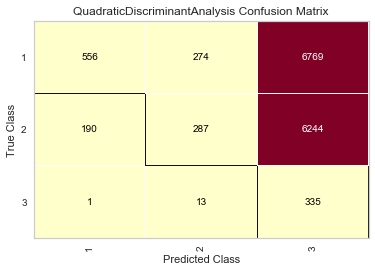

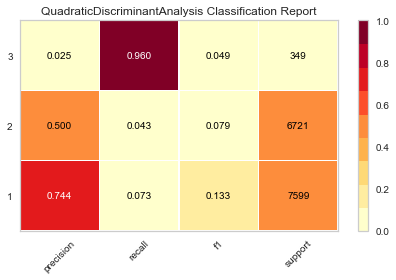

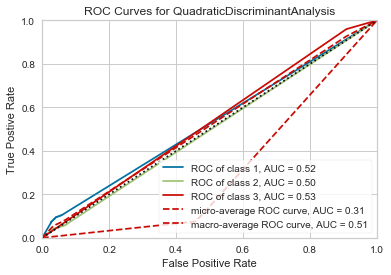

c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\sklearn\discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\sklearn\discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\sklearn\discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


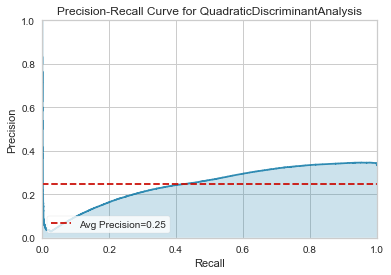

NameError: name 'disc_thresh' is not defined

In [101]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
qda = QDA()
qda.fit(X_train_continuous, y_train.values.ravel())
cutoffs_qda, scores_qda = analyze_classifier(qda, X_train_continuous, X_test_continuous, y_train, y_test)
predict_qda = qda.predict(X_test_fe)
prob_qda = qda.predict_proba(X_test_fe)
best_cutoff_qda = pd.Series(cutoffs_qda)[pd.Series(list(scores_qda['fscore'])).idxmax()]
adj_acc_qda, adj_conf_matrix_qda, new_preds_qda = compute_new_conf_matrix(predict_qda, prob_qda, best_cutoff_qda, y_test)
acc_qda = round(accuracy_score(y_test, predict_qda),5)
print(f'QDA Accuracy {acc_qda}')
print(f'Cutoff ({round(best_cutoff_qda,4)}) adjusted accuracy: {adj_acc_qda}')
print(new_preds_qda.iloc[new_preds_qda[new_preds_qda.Predict == 1]['ProbTrue'].argmin()])
print(new_preds_qda.iloc[new_preds_qda[new_preds_qda.NewPredict == 1]['ProbTrue'].argmin()])
print(f'50/50 Accuracy {acc_qda} is {"better than baseline" if acc_qda > baseline_accuracy_test else "worse than baseline"}')
print(f'Cutoff Adjusted Accuracy {adj_acc_qda} is {"better than baseline" if adj_acc_qda > baseline_accuracy_test else "worse than baseline"}')
adj_conf_matrix_qda

In [63]:
from sklearn.svm import SVC
support_vec_model = SVC(gamma='auto', kernel='linear', C=0.01)
support_vec_model.fit(X_train_fe, y_train.values.ravel())
#analyze_classifier(support_vec_model, X_train_fe, X_test_fe, y_train, y_test)

SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

### Naive Bayes

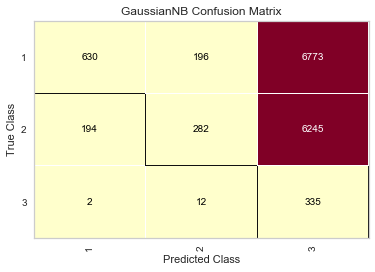

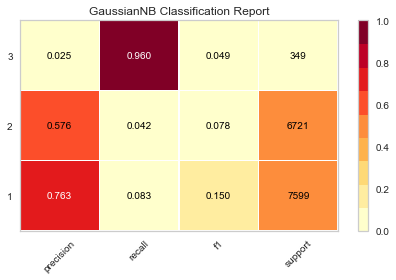

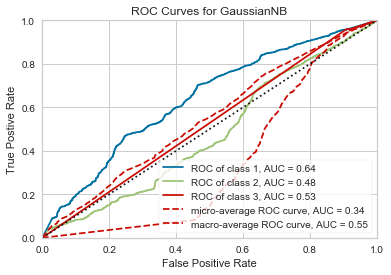

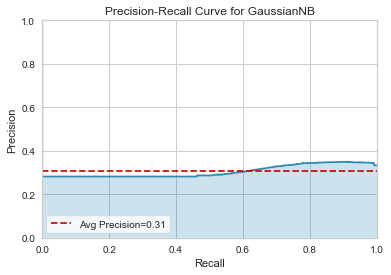

NameError: name 'disc_thresh' is not defined

In [102]:
nb = GaussianNB(
   var_smoothing=1e-9
)
cutoffs_nb, scores_nb = analyze_classifier(nb, X_train_fe, X_test_fe, y_train, y_test)
predict_nb = nb.predict(X_test_fe)
prob_nb = nb.predict_proba(X_test_fe)
best_cutoff_nb = pd.Series(cutoffs_nb)[pd.Series(list(scores_nb['fscore'])).idxmax()]
adj_acc_nb, adj_conf_matrix_nb, new_preds_nb = compute_new_conf_matrix(predict_qda, prob_qda, best_cutoff_qda, y_test)
acc_nb = round(accuracy_score(y_test, predict_nb),5)
print(f'NB Accuracy {acc_nb}')
print(f'Cutoff ({round(best_cutoff_nb,4)}) adjusted accuracy: {adj_acc_nb}')
print(new_preds_nb.iloc[new_preds_nb[new_preds_nb.Predict == 1]['ProbTrue'].argmin()])
print(new_preds_nb.iloc[new_preds_nb[new_preds_nb.NewPredict == 1]['ProbTrue'].argmin()])
print(f'50/50 Accuracy {acc_nb} is {"better than baseline" if acc_nb > baseline_accuracy_test else "worse than baseline"}')
print(f'Cutoff Adjusted Accuracy {adj_acc_nb} is {"better than baseline" if adj_acc_nb > baseline_accuracy_test else "worse than baseline"}')
adj_conf_matrix_nb

### Random forest classifier

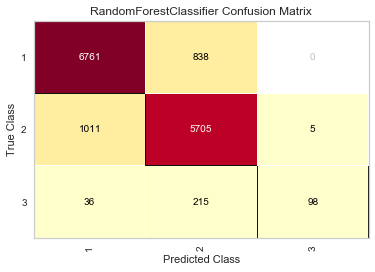

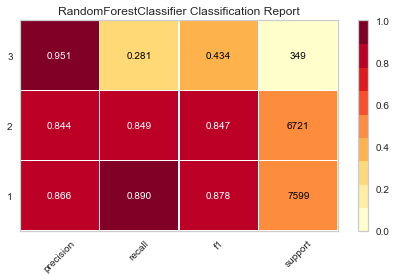

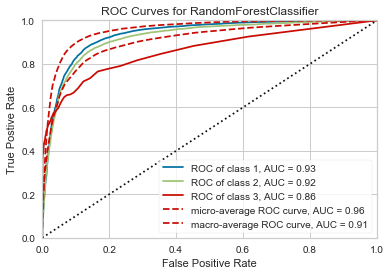

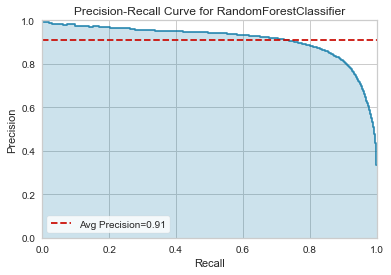

NameError: name 'disc_thresh' is not defined

In [103]:
rf_classifier = RandomForestClassifier(
  #max_depth=None,
  random_state=0,
  #bootstrap=True,
  #oob_score=True,
  #max_samples = 50,
  criterion='gini',
  n_estimators=200
)
rf_classifier.fit(X_train_fe, y_train.values.ravel())
cutoffs_rf, scores_rf = analyze_classifier(rf_classifier, X_train_fe, X_test_fe, y_train, y_test)
predict_rf = nb.predict(X_test_fe)
prob_rf = nb.predict_proba(X_test_fe)
best_cutoff_rf = pd.Series(cutoffs_rf)[pd.Series(list(scores_rf['fscore'])).idxmax()]
adj_acc_rf, adj_conf_matrix_rf, new_preds_rf = compute_new_conf_matrix(predict_rf, prob_rf, best_cutoff_rf, y_test)
acc_rf = round(accuracy_score(y_test, predict_rf),5)
print(f'RF Accuracy {acc_rf}')
print(f'Cutoff ({round(best_cutoff_rf,4)}) adjusted accuracy: {adj_acc_rf}')
print(new_preds_rf.iloc[new_preds_rf[new_preds_rf.Predict == 1]['ProbTrue'].argmin()])
print(new_preds_rf.iloc[new_preds_rf[new_preds_rf.NewPredict == 1]['ProbTrue'].argmin()])
print(f'50/50 Accuracy {acc_rf} is {"better than baseline" if acc_rf > baseline_accuracy_test else "worse than baseline"}')
print(f'Cutoff Adjusted Accuracy {adj_acc_rf} is {"better than baseline" if adj_acc_rf > baseline_accuracy_test else "worse than baseline"}')
adj_conf_matrix_rf

### VIF Factors for Final Model

In [104]:
vif = sklearn_vif(X_train_fe.columns, data_final.drop(columns=['Response']))

c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in double_scalars
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in double_scalars
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in double_scalars
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in double_scalars
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in double_scalars
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in double_scalars
c:\users\skennedy\appdata\lo

c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in double_scalars
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in double_scalars
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in double_scalars
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in double_scalars
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in double_scalars
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in double_scalars
c:\users\skennedy\appdata\lo

c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in double_scalars
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in double_scalars
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in double_scalars
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in double_scalars
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in double_scalars
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in double_scalars
c:\users\skennedy\appdata\lo

c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in double_scalars
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in double_scalars
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in double_scalars
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in double_scalars
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in double_scalars
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in double_scalars
c:\users\skennedy\appdata\lo

c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in double_scalars
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in double_scalars
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in double_scalars
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in double_scalars
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in double_scalars
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in double_scalars
c:\users\skennedy\appdata\lo

In [105]:
#rf.feature_importance_
vif

,VIF,Tolerance
latitude,98.008034,0.010203
longitude,40.891965,0.024455
price,1.088813,0.918431
minimum_nights,1.075593,0.929720
number_of_reviews,1.657805,0.603207
...,...,...
reviews_per_month_cut_Less Than 2,inf,0.000000
reviews_per_month_cut_Less Than Three,inf,0.000000
reviews_per_month_cut_Less Than Four,inf,0.000000
reviews_per_month_cut_Less Than Five,inf,0.000000


In [68]:
roc_curve(y_test, predicted_probs.NewPredict)

NameError: name 'predicted_probs' is not defined

In [ ]:
roc_auc_score(y_test, predicted_probs.NewPredict)

In [ ]:
vif = sklearn_vif(features.columns, data_final.drop(columns=['Response']))

In [ ]:
# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
pca = PCA()
# set the tolerance to a large value to make the example faster
#logistic = LogisticRegression(max_iter=10000, tol=0.1)
pipe = Pipeline(steps=[('pre-process',StandardScaler()), ('pca', pca), ('logistic', lgrg_all)])

#X, y = datasets.load_digits(return_X_y=True)

# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'pca__n_components': [5, 15, 30, 45, 64, 131],
    'logistic__C': np.logspace(-4, 4, 4),
}
search = GridSearchCV(pipe, param_grid, n_jobs=-1)
search.fit(X_train, y_train.values.ravel())
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

# Plot the PCA spectrum
pca.fit(X_train)

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax0.plot(np.arange(1, pca.n_components_ + 1),
         pca.explained_variance_ratio_, '+', linewidth=2)
ax0.set_ylabel('PCA explained variance ratio')

ax0.axvline(search.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
ax0.legend(prop=dict(size=12))

# For each number of components, find the best classifier results
results = pd.DataFrame(search.cv_results_)
components_col = 'param_pca__n_components'
best_clfs = results.groupby(components_col).apply(
    lambda g: g.nlargest(1, 'mean_test_score'))

best_clfs.plot(x=components_col, y='mean_test_score', yerr='std_test_score',
               legend=False, ax=ax1)
ax1.set_ylabel('Classification accuracy (val)')
ax1.set_xlabel('n_components')

plt.xlim(-1, 150)

plt.tight_layout()
plt.show()

In [ ]:
pca.explained_variance_ratio_.sum()